In [1]:
interactive = False
if interactive:
    %matplotlib
import numpy as np
import h5py
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import yaml
import argparse
import xml.etree.ElementTree as ET

sys.path.append('../')
import utils
import settings
plt.style.use('../spectrum.mplstyle')
if interactive:
    plt.ion()

In [2]:
def multi_exp_fit(param_data_object, t, corr, result_type="ct"):
    n = [2.0,1.0,1.0,1.0]
    param_info = param_data_object['param_info'][corr].attrs
    for i in range(0,4):
        if f'N{i+2}' in param_info.keys():
            n[i] = float(param_info[f'N{i+2}'])
    print(n)
    param_data = param_data_object['params']['Values']
    param_samplings = [param_data[f'<MCObservable><Info>{fit_param}<|Info><|MCObservable>'][()] for fit_param in param_info['FitParams']]
#     print(corr,param_samplings)
    function_vals = []
    function_errs = []
    print(param_samplings[0][0],param_samplings[0][0]+param_samplings[1][0]**2,param_samplings[0][0]+n[0]*param_samplings[1][0]**2,
          param_samplings[0][0]+n[1]*param_samplings[1][0]**2,param_samplings[0][0]+n[2]*param_samplings[1][0]**2,
          param_samplings[0][0]+n[3]*param_samplings[1][0]**2)
#     print(param_samplings[2][0], 
#                    param_samplings[3][0], param_samplings[4][0], param_samplings[5][0], 
#                    param_samplings[6][0], param_samplings[7][0])
    for tval in t:
        if result_type=="ct":
            function_samplings = utils.multi_exp_func(tval, param_samplings[0], param_samplings[1], param_samplings[2], 
                   param_samplings[3], param_samplings[4], param_samplings[5], 
                   param_samplings[6], param_samplings[7],n[0],n[1], n[2],n[3])
        else:
            function_samplings = utils.multi_exp_func_eff(tval, param_samplings[0], param_samplings[1], param_samplings[2], 
                   param_samplings[3], param_samplings[4], param_samplings[5], 
                   param_samplings[6], param_samplings[7],n[0],n[1], n[2],n[3])
        function_vals.append(function_samplings[0])
        function_errs.append(utils.bootstrap_error_by_array(function_samplings))
    return np.array(function_vals),np.array(function_errs)

In [3]:
def get_fit_range(param_data_object, corr):
    try:
        param_info = param_data_object['param_info'][corr].attrs
        return param_info["FinalTmin"], param_info["FinalTmax"]
    except Exception as error:
        print(error)
        return None,None

In [4]:
data_files = {
    "single_hadrons.hdf5":'single_hadrons',
    "rotated_correlators-lambda.hdf5":'rotated_correlators',
    "rotated_correlators-nn.hdf5":'rotated_correlators'
}
param_files = {
#     "t=[2,17],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-17.hdf5",
#     "t=[2,19],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-19-3.hdf5",
#     "t=[2,21],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-21.hdf5",
#     "t=[2,23],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-23.hdf5",
#     "t=[2,25],gap=2.5": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-25.hdf5",
    "t=[2,25],gap=2.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-2.hdf5",
    "t=[2,25],gap=1.5": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-15.hdf5",
    "t=[2,25],gap=1.25": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-125.hdf5",
    "t=[2,25],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25.hdf5",
    "t=[2,25],gap=0.75": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-075.hdf5",
#     "t=[2,25],gap=0.75,0.25": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-075-025.hdf5",
#     "t=[2,25],gap=0.50": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-050.hdf5",
#     "t=[2,25],gap=0.25": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-025.hdf5",
#     "t=[2,19],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-19.hdf5",
#     "t=[2,19]*,gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-19-2.hdf5",
}
# param_files = {
#     "gap=0.75": "param_samplings_isosinglet_nonstrange_nucleonnucleon_multi_rebin10-075.hdf5",
#     "gap=1.0": "param_samplings_isosinglet_nonstrange_nucleonnucleon_multi_rebin10.hdf5",
#     "gap=1.2": "param_samplings_isosinglet_nonstrange_nucleonnucleon_multi_rebin10-12.hdf5",
# }
# param_files = {
#     "2-exp": "param_samplings_isosinglet_strange_fermionic_multi_new_rebin10.hdf5",
# }
johns_data_file = "nucleon_d0_emass_1_0_errs.dat"
n_corr = 'isodoublet S=0 P=(0,0,0) G1g N[SS0] 0'

available_corrs = []
for file in param_files:
    param_samplings = h5py.File(param_files[file],"r")
    available_corrs += list( param_samplings['param_info'].keys() )
    param_samplings.close()

In [5]:
data_files

{'single_hadrons.hdf5': 'single_hadrons',
 'rotated_correlators-lambda.hdf5': 'rotated_correlators',
 'rotated_correlators-nn.hdf5': 'rotated_correlators'}

In [6]:
available_corrs = list(set(available_corrs))
if interactive:
    available_corrs = [n_corr]
    
# available_corrs = ['isosinglet S=0 P=(0,0,0) T1g ROT 0']
# available_corrs = [n_corr, 'isodoublet S=0 PSQ=1 G1 N[SS0] 0','isodoublet S=0 PSQ=2 G N[SS0] 0','isodoublet S=0 PSQ=3 G N[SS0] 0','isodoublet S=0 PSQ=4 G1 N[SS0] 0']

In [7]:
available_corrs

['isosinglet S=-1 PSQ=1 G2 ROT 5',
 'isosinglet S=-1 PSQ=3 G ROT 3',
 'isosinglet S=-1 PSQ=1 G1 ROT 4',
 'isosinglet S=-1 PSQ=3 F1 ROT 1',
 'isosinglet S=-1 PSQ=3 F1 ROT 5',
 'isodoublet S=-1 PSQ=3 A2 k[SS0] 0',
 'isosinglet S=-1 PSQ=2 G ROT 3',
 'isosinglet S=-1 PSQ=2 G ROT 8',
 'isosinglet S=-1 PSQ=3 F2 ROT 1',
 'isosinglet S=-1 PSQ=3 G ROT 8',
 'isosinglet S=-1 PSQ=3 G ROT 9',
 'isotriplet S=-1 PSQ=1 G1 S[SS0] 0',
 'isosinglet S=-1 PSQ=3 G ROT 2',
 'isosinglet S=-1 PSQ=3 G ROT 6',
 'isosinglet S=-1 P=(0,0,0) G1g L[SS0] 0',
 'isosinglet S=-1 P=(0,0,0) G1u ROT 7',
 'isotriplet S=-1 PSQ=3 G S[SS0] 0',
 'isosinglet S=-1 PSQ=1 G1 ROT 6',
 'isodoublet S=0 PSQ=1 G1 N[SS0] 0',
 'isosinglet S=-1 PSQ=2 G ROT 0',
 'isosinglet S=-1 P=(0,0,0) G1g ROT 1',
 'isosinglet S=-1 PSQ=2 G ROT 13',
 'isotriplet S=0 PSQ=3 A2m P[SS0] 0',
 'isosinglet S=-1 P=(0,0,0) Hu ROT 0',
 'isosinglet S=-1 PSQ=1 G1 ROT 0',
 'isosinglet S=-1 P=(0,0,0) G1u ROT 5',
 'isosinglet S=-1 PSQ=3 F1 ROT 2',
 'isosinglet S=-1 PSQ=3

In [8]:
omit = {}
fit_range = {}
chi2 = {}
for corr in available_corrs:
    fit_range[corr] = {}
    chi2[corr] = {}
for dataset in param_files.keys():
    hdf5_data = h5py.File(param_files[dataset],"r")
    for corr in available_corrs:
        tmin, tmax = get_fit_range(hdf5_data,corr)
        if tmin is not None:
            fit_range[corr][dataset] = tmax-tmin
            chi2[corr][dataset] = hdf5_data['param_info'][corr].attrs['ChiSquarePerDof']
    hdf5_data.close()
            
for corr in available_corrs:
    omit[corr] = []
#     min_range = min(fit_range[corr].values())
#     max_chisqr = max(chi2[corr].values())
#     for dataset in fit_range[corr].keys():
#         if fit_range[corr][dataset]==min_range:
#             omit[corr].append(dataset)
#             break
#     for dataset in chi2[corr].keys():
#         if (chi2[corr][dataset]==max_chisqr) and (max_chisqr>2.0):
#             omit[corr].append(dataset)
#             break

"Unable to open object (object 'isosinglet S=-1 PSQ=1 G1 ROT 7' doesn't exist)"


isosinglet S=-1 PSQ=1 G2 ROT 5
[3.0, 5.0, 1.0, 1.0]
0.5917898887397539 0.8702994235538392 1.4273184931820095 1.98433756281018 0.8702994235538392 0.8702994235538392
[3.0, 5.0, 1.0, 1.0]
0.5917898887397539 0.8702994235538392 1.4273184931820095 1.98433756281018 0.8702994235538392 0.8702994235538392
[2.5, 4.0, 1.0, 1.0]
0.5929728432682173 0.8819854802749485 1.3155044357850454 1.7490233912951423 0.8819854802749485 0.8819854802749485
[2.5, 4.0, 1.0, 1.0]
0.5929728432682173 0.8819854802749485 1.3155044357850454 1.7490233912951423 0.8819854802749485 0.8819854802749485
[2.25, 4.75, 1.0, 1.0]
0.5911190441940687 0.8547711962094486 1.1843363862286735 1.8434667662671234 0.8547711962094486 0.8547711962094486
[2.25, 4.75, 1.0, 1.0]
0.5911190441940687 0.8547711962094486 1.1843363862286735 1.8434667662671234 0.8547711962094486 0.8547711962094486
[2.0, 4.0, 1.0, 1.0]
0.5928688565271831 0.878741896374651 1.164614936222119 1.7363610159170548 0.878741896374651 0.878741896374651
[2.0, 4.0, 1.0, 1.0]
0.59286

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[3.0, 7.0, 1.0, 1.0]
0.6040258320441192 0.8550568172055029 1.35711878752827 2.3612427281738047 0.8550568172055029 0.8550568172055029
[3.0, 7.0, 1.0, 1.0]
0.6040258320441192 0.8550568172055029 1.35711878752827 2.3612427281738047 0.8550568172055029 0.8550568172055029
[2.5, 5.5, 1.0, 1.0]
0.6066087804216946 0.8654191593799222 1.2536347278172635 2.030065864691946 0.8654191593799222 0.8654191593799222
[2.5, 5.5, 1.0, 1.0]
0.6066087804216946 0.8654191593799222 1.2536347278172635 2.030065864691946 0.8654191593799222 0.8654191593799222
[2.25, 6.0, 1.0, 1.0]
0.6059097723515324 0.8362298222593633 1.1241298846441519 1.9878300717985176 0.8362298222593633 0.8362298222593633
[2.25, 6.0, 1.0, 1.0]
0.6059097723515324 0.8362298222593633 1.1241298846441519 1.9878300717985176 0.8362298222593633 0.8362298222593633
[2.0, 5.0, 10.0, 1.0]
0.603099641757934 0.7853882226982027 0.9676768036384715 1.5145425464592779 2.425985451160622 0.7853882226982027
[2.0, 5.0, 10.0, 1.0]
0.603099641757934 0.7853882226982027 0

isosinglet S=-1 PSQ=3 G ROT 9
[3.0, 5.0, 7.0, 13.0]
0.5262566732200604 0.650520752378061 0.899048910694062 1.147577069010063 1.3961052273260641 2.141689702274067
[3.0, 5.0, 7.0, 13.0]
0.5262566732200604 0.650520752378061 0.899048910694062 1.147577069010063 1.3961052273260641 2.141689702274067
[4.0, 8.5, 11.5, 1.0]
0.5296729431181769 0.6715543063783832 1.0971983961590022 1.7356645308299306 2.161308620610549 0.6715543063783832
[4.0, 8.5, 11.5, 1.0]
0.5296729431181769 0.6715543063783832 1.0971983961590022 1.7356645308299306 2.161308620610549 0.6715543063783832
[3.5, 6.0, 9.75, 1.0]
0.537433107826435 0.7084843407505045 1.136112423060678 1.5637405053708515 2.205182628836112 0.7084843407505045
[3.5, 6.0, 9.75, 1.0]
0.537433107826435 0.7084843407505045 1.136112423060678 1.5637405053708515 2.205182628836112 0.7084843407505045
[3.0, 4.0, 6.0, 12.0]
0.5286126087140427 0.6651302383073951 0.9381654974941003 1.0746831270874528 1.3477183862741577 2.166824163834273
[3.0, 4.0, 6.0, 12.0]
0.52861260871

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[3.0, 1.0, 1.0, 1.0]
0.7910446186491891 1.2416199678796882 2.1427706663406862 1.2416199678796882 1.2416199678796882 1.2416199678796882
[2.5, 1.0, 1.0, 1.0]
0.8029268819866018 1.2490025598464634 1.918116076636256 1.2490025598464634 1.2490025598464634 1.2490025598464634
[2.5, 1.0, 1.0, 1.0]
0.8029268819866018 1.2490025598464634 1.918116076636256 1.2490025598464634 1.2490025598464634 1.2490025598464634
[2.25, 1.0, 1.0, 1.0]
0.8117323253584141 1.280557980177148 1.8665900487005653 1.280557980177148 1.280557980177148 1.280557980177148
[2.25, 1.0, 1.0, 1.0]
0.8117323253584141 1.280557980177148 1.8665900487005653 1.280557980177148 1.280557980177148 1.280557980177148
[3.0, 1.0, 1.0, 1.0]
0.7910446186491891 1.2416199678796882 2.1427706663406862 1.2416199678796882 1.2416199678796882 1.2416199678796882
[3.0, 1.0, 1.0, 1.0]
0.7910446186491891 1.2416199678796882 2.1427706663406862 1.2416199678796882 1.2416199678796882 1.2416199678796882
[2.5, 1.0, 1.0, 1.0]
0.8029268819866018 1.2490025598464634 1.91

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[3.0, 1.0, 1.0, 1.0]
0.5611266911711473 0.9393912769679834 1.6959204485616555 0.9393912769679834 0.9393912769679834 0.9393912769679834
[2.5, 4.0, 1.0, 1.0]
0.5575128351655095 0.9187098133230718 1.460505280559415 2.002300747795758 0.9187098133230718 0.9187098133230718
[2.5, 4.0, 1.0, 1.0]
0.5575128351655095 0.9187098133230718 1.460505280559415 2.002300747795758 0.9187098133230718 0.9187098133230718
[2.25, 3.5, 1.0, 1.0]
0.5580118524257844 0.9272439627040578 1.3887841005518995 1.8503242383997411 0.9272439627040578 0.9272439627040578
[2.25, 3.5, 1.0, 1.0]
0.5580118524257844 0.9272439627040578 1.3887841005518995 1.8503242383997411 0.9272439627040578 0.9272439627040578
[2.0, 4.0, 1.0, 1.0]
0.5570107352149839 0.8990043699232609 1.240998004631538 1.9249852740480922 0.8990043699232609 0.8990043699232609
[2.0, 4.0, 1.0, 1.0]
0.5570107352149839 0.8990043699232609 1.240998004631538 1.9249852740480922 0.8990043699232609 0.8990043699232609
[1.75, 3.25, 1.0, 1.0]
0.558368275545222 0.934914084300134 

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[5.0, 1.0, 1.0, 1.0]
0.6648066041046445 0.9450302023389014 2.065924595275929 0.9450302023389014 0.9450302023389014 0.9450302023389014
[4.0, 1.0, 1.0, 1.0]
0.6560467774005566 0.90509433691647 1.6522370154642103 0.90509433691647 0.90509433691647 0.90509433691647
[4.0, 1.0, 1.0, 1.0]
0.6560467774005566 0.90509433691647 1.6522370154642103 0.90509433691647 0.90509433691647 0.90509433691647
[3.5, 4.75, 1.0, 1.0]
0.6608722144029497 0.9233563688907837 1.5795667551103685 1.9076719482201607 0.9233563688907837 0.9233563688907837
[3.5, 4.75, 1.0, 1.0]
0.6608722144029497 0.9233563688907837 1.5795667551103685 1.9076719482201607 0.9233563688907837 0.9233563688907837
[4.0, 1.0, 1.0, 1.0]
0.6560467672903234 0.9050943091168288 1.652236934596345 0.9050943091168288 0.9050943091168288 0.9050943091168288
[4.0, 1.0, 1.0, 1.0]
0.6560467672903234 0.9050943091168288 1.652236934596345 0.9050943091168288 0.9050943091168288 0.9050943091168288
[3.25, 4.0, 1.0, 1.0]
0.6626797172564601 0.9297528821903616 1.5306675032

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[3.0, 5.0, 1.0, 1.0]
0.5685255796222062 0.948231721809143 1.7076440061830167 2.46705629055689 0.948231721809143 0.948231721809143
[2.5, 4.0, 1.0, 1.0]
0.568341637717303 0.9427164459055823 1.5042786581880012 2.0658408704704203 0.9427164459055823 0.9427164459055823
[2.5, 4.0, 1.0, 1.0]
0.568341637717303 0.9427164459055823 1.5042786581880012 2.0658408704704203 0.9427164459055823 0.9427164459055823
[2.25, 3.5, 1.0, 1.0]
0.5690540852300323 0.9533672607971518 1.4337587302560513 1.9141501997149506 0.9533672607971518 0.9533672607971518
[2.25, 3.5, 1.0, 1.0]
0.5690540852300323 0.9533672607971518 1.4337587302560513 1.9141501997149506 0.9533672607971518 0.9533672607971518
[2.0, 3.0, 5.0, 1.0]
0.5652552971133438 0.8707576392714276 1.1762599814295114 1.4817623235875954 2.0927670079037632 0.8707576392714276
[2.0, 3.0, 5.0, 1.0]
0.5652552971133438 0.8707576392714276 1.1762599814295114 1.4817623235875954 2.0927670079037632 0.8707576392714276
[2.5, 4.0, 1.0, 1.0]
0.5683416400953246 0.9427164670498195 1

[4.0, 7.0, 10.0, 1.0]
0.2076736835025319 0.28752474302153186 0.5270779215785317 0.7666311001355317 1.0061842786925315 0.28752474302153186
[4.0, 7.0, 10.0, 1.0]
0.2076736835025319 0.28752474302153186 0.5270779215785317 0.7666311001355317 1.0061842786925315 0.28752474302153186
[3.5, 6.0, 1.0, 1.0]
0.2079639559685563 0.32759543559122445 0.6266741346478948 0.9257528337045652 0.32759543559122445 0.32759543559122445
[3.5, 6.0, 1.0, 1.0]
0.2079639559685563 0.32759543559122445 0.6266741346478948 0.9257528337045652 0.32759543559122445 0.32759543559122445
[3.0, 5.0, 12.0, 1.0]
0.20860509252229423 0.38193336312168313 0.728589904320461 1.075246445519239 2.2885443397149614 0.38193336312168313
[3.0, 5.0, 12.0, 1.0]
0.20860509252229423 0.38193336312168313 0.728589904320461 1.075246445519239 2.2885443397149614 0.38193336312168313
[3.25, 5.5, 12.25, 1.0]
0.20840000143689918 0.3627871253551648 0.7101581541712625 1.05752918298736 2.0996422694356527 0.3627871253551648
[3.25, 5.5, 12.25, 1.0]
0.20840000143

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


 1.062963060597011 1.8311628311700963 1.062963060597011 1.062963060597011 1.062963060597011
[3.0, 1.0, 1.0, 1.0]
0.6788631753104685 1.062963060597011 1.8311628311700963 1.062963060597011 1.062963060597011 1.062963060597011
[2.5, 8.5, 1.0, 1.0]
0.6719689152099155 0.9884393760955321 1.463145067423957 3.3619678327376565 0.9884393760955321 0.9884393760955321
[2.5, 8.5, 1.0, 1.0]
0.6719689152099155 0.9884393760955321 1.463145067423957 3.3619678327376565 0.9884393760955321 0.9884393760955321
[2.25, 7.25, 1.0, 1.0]
0.676081945649188 0.9915765285636075 1.385944757206632 2.9634176717787293 0.9915765285636075 0.9915765285636075
[2.25, 7.25, 1.0, 1.0]
0.676081945649188 0.9915765285636075 1.385944757206632 2.9634176717787293 0.9915765285636075 0.9915765285636075
[2.0, 6.0, 1.0, 1.0]
0.6645983837447859 0.8585724546554621 1.0525465255661384 1.8284428092088434 0.8585724546554621 0.8585724546554621
[2.0, 6.0, 1.0, 1.0]
0.6645983837447859 0.8585724546554621 1.0525465255661384 1.8284428092088434 0.85857

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[3.0, 5.0, 1.0, 1.0]
0.5891302851225769 0.8280571182906193 1.3059107846267044 1.7837644509627895 0.8280571182906193 0.8280571182906193
[4.0, 1.0, 1.0, 1.0]
0.5853322141729428 0.8375476166327261 1.594193824012076 0.8375476166327261 0.8375476166327261 0.8375476166327261
[4.0, 1.0, 1.0, 1.0]
0.5853322141729428 0.8375476166327261 1.594193824012076 0.8375476166327261 0.8375476166327261 0.8375476166327261
[3.5, 1.0, 1.0, 1.0]
0.615878731849896 0.9031185773440764 1.6212181910795276 0.9031185773440764 0.9031185773440764 0.9031185773440764
[3.5, 1.0, 1.0, 1.0]
0.615878731849896 0.9031185773440764 1.6212181910795276 0.9031185773440764 0.9031185773440764 0.9031185773440764
[3.0, 4.0, 1.0, 1.0]
0.6017738606961971 0.865655614216966 1.3934191212585036 1.6573008747792726 0.865655614216966 0.865655614216966
[3.0, 4.0, 1.0, 1.0]
0.6017738606961971 0.865655614216966 1.3934191212585036 1.6573008747792726 0.865655614216966 0.865655614216966
[3.25, 4.0, 1.0, 1.0]
0.6022210142650519 0.8685871902907334 1.467

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[3.0, 5.0, 1.0, 1.0]
0.6528151085151904 0.9937974044285391 1.6757619962552366 2.3577265880819342 0.9937974044285391 0.9937974044285391
[2.5, 4.0, 1.0, 1.0]
0.6514579243251097 0.9838684003774655 1.482484114455999 1.9810998285345327 0.9838684003774655 0.9838684003774655
[2.5, 4.0, 1.0, 1.0]
0.6514579243251097 0.9838684003774655 1.482484114455999 1.9810998285345327 0.9838684003774655 0.9838684003774655
[2.25, 3.5, 1.0, 1.0]
0.6533813083233762 0.995463057424437 1.423065243800763 1.850667430177089 0.995463057424437 0.995463057424437
[2.25, 3.5, 1.0, 1.0]
0.6533813083233762 0.995463057424437 1.423065243800763 1.850667430177089 0.995463057424437 0.995463057424437
[2.0, 4.0, 1.0, 1.0]
0.6492679963308511 0.9623943235940466 1.275520650857242 1.901773305383633 0.9623943235940466 0.9623943235940466
[2.0, 4.0, 1.0, 1.0]
0.6492679963308511 0.9623943235940466 1.275520650857242 1.901773305383633 0.9623943235940466 0.9623943235940466
[2.5, 4.0, 1.0, 1.0]
0.651457927581918 0.9838684103004265 1.482484134

[3.0, 5.0, 9.0, 1.0]
0.5223083930865757 0.7116864833409877 1.0904426638498117 1.4691988443586357 2.226711205376284 0.7116864833409877
[2.5, 4.0, 5.5, 11.5]
0.5204660800069071 0.6990321003203417 0.9668811307904934 1.2347301612606452 1.5025791917307971 2.5739753136114043
[2.5, 4.0, 5.5, 11.5]
0.5204660800069071 0.6990321003203417 0.9668811307904934 1.2347301612606452 1.5025791917307971 2.5739753136114043
[3.5, 4.75, 11.0, 1.0]
0.5208439039638045 0.7115497482865429 1.188314359093389 1.426696664496812 2.618608191513927 0.7115497482865429
[3.5, 4.75, 11.0, 1.0]
0.5208439039638045 0.7115497482865429 1.188314359093389 1.426696664496812 2.618608191513927 0.7115497482865429
[3.0, 4.0, 6.0, 11.0]
0.5207726515924416 0.7052474373201639 1.0741970087756085 1.258671794503331 1.6276213659587757 2.5499952945973874
[3.0, 4.0, 6.0, 11.0]
0.5207726515924416 0.7052474373201639 1.0741970087756085 1.258671794503331 1.6276213659587757 2.5499952945973874
[2.5, 4.0, 4.75, 11.5]
0.5205572457831188 0.700661117999

<ipython-input-9-c8981c1ce55c>:80: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  john_data = pd.read_csv(johns_data_file, header=None,skiprows=6,delimiter="   ")


isosinglet S=-1 PSQ=2 G ROT 2
[3.0, 7.0, 1.0, 1.0]
0.48376141484687896 0.6853004545943007 1.088378534089144 1.894534693078831 0.6853004545943007 0.6853004545943007
[3.0, 7.0, 1.0, 1.0]
0.48376141484687896 0.6853004545943007 1.088378534089144 1.894534693078831 0.6853004545943007 0.6853004545943007
[2.5, 1.0, 1.0, 1.0]
0.48489607300964127 0.6729735429248664 0.9550897477977043 0.6729735429248664 0.6729735429248664 0.6729735429248664
[2.5, 1.0, 1.0, 1.0]
0.48489607300964127 0.6729735429248664 0.9550897477977043 0.6729735429248664 0.6729735429248664 0.6729735429248664
[2.25, 1.0, 1.0, 1.0]
0.48564285663594176 0.6750132626379916 0.9117262701405539 0.6750132626379916 0.6750132626379916 0.6750132626379916
[2.25, 1.0, 1.0, 1.0]
0.48564285663594176 0.6750132626379916 0.9117262701405539 0.6750132626379916 0.6750132626379916 0.6750132626379916
[3.0, 1.0, 1.0, 1.0]
0.48403081375657075 0.6738040539675175 1.053350534389411 0.6738040539675175 0.6738040539675175 0.6738040539675175
[3.0, 1.0, 1.0, 1.0]


..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[3.0, 5.0, 1.0, 1.0]
0.6124323608346862 0.9206678307768071 1.5371387706610489 2.153609710545291 0.9206678307768071 0.9206678307768071
[2.5, 4.0, 1.0, 1.0]
0.6131237764381081 0.9275570607926488 1.3992069873244597 1.8708569138562707 0.9275570607926488 0.9275570607926488
[2.5, 4.0, 1.0, 1.0]
0.6131237764381081 0.9275570607926488 1.3992069873244597 1.8708569138562707 0.9275570607926488 0.9275570607926488
[2.25, 3.5, 6.0, 1.0]
0.609785524541273 0.8762190831303432 1.209261031366681 1.542302979603019 2.2083868760756946 0.8762190831303432
[2.25, 3.5, 6.0, 1.0]
0.609785524541273 0.8762190831303432 1.209261031366681 1.542302979603019 2.2083868760756946 0.8762190831303432
[2.0, 4.0, 1.0, 1.0]
0.6129527118084034 0.9218518154997652 1.230750919191127 1.8485491265738507 0.9218518154997652 0.9218518154997652
[2.0, 4.0, 1.0, 1.0]
0.6129527118084034 0.9218518154997652 1.230750919191127 1.8485491265738507 0.9218518154997652 0.9218518154997652
[2.5, 3.25, 6.25, 1.0]
0.6093566701626805 0.8761659130144108 1

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[3.0, 5.0, 1.0, 1.0]
0.6859759698862892 1.0080617682416975 1.6522333649525138 2.29640496166333 1.0080617682416975 1.0080617682416975
[2.5, 4.0, 1.0, 1.0]
0.6871984500976431 1.0155065694186498 1.50796874840016 2.00043092738167 1.0155065694186498 1.0155065694186498
[2.5, 4.0, 1.0, 1.0]
0.6871984500976431 1.0155065694186498 1.50796874840016 2.00043092738167 1.0155065694186498 1.0155065694186498
[2.25, 4.75, 1.0, 1.0]
0.6849853993579156 0.9834175477111302 1.3564577331526486 2.102538104035685 0.9834175477111302 0.9834175477111302
[2.25, 4.75, 1.0, 1.0]
0.6849853993579156 0.9834175477111302 1.3564577331526486 2.102538104035685 0.9834175477111302 0.9834175477111302
[2.0, 4.0, 1.0, 1.0]
0.6870368423131344 1.0078866253274206 1.3287364083417064 1.9704359743702784 1.0078866253274206 1.0078866253274206
[2.0, 4.0, 1.0, 1.0]
0.6870368423131344 1.0078866253274206 1.3287364083417064 1.9704359743702784 1.0078866253274206 1.0078866253274206
[1.75, 4.0, 1.0, 1.0]
0.6871416871295751 1.0038361908947957 1.2

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


 0.9370469727013875 1.470610286351951 2.0041736000025145 0.9370469727013875 0.9370469727013875
[3.0, 5.0, 1.0, 1.0]
0.6702653158761057 0.9370469727013875 1.470610286351951 2.0041736000025145 0.9370469727013875 0.9370469727013875
[2.5, 4.0, 1.0, 1.0]
0.6728509196514705 0.9527419064921656 1.3725783867532084 1.7924148670142512 0.9527419064921656 0.9527419064921656
[2.5, 4.0, 1.0, 1.0]
0.6728509196514705 0.9527419064921656 1.3725783867532084 1.7924148670142512 0.9527419064921656 0.9527419064921656
[2.25, 4.75, 1.0, 1.0]
0.6693122132269055 0.9175087978743137 1.2277545286835738 1.8482459903020945 0.9175087978743137 0.9175087978743137
[2.25, 4.75, 1.0, 1.0]
0.6693122132269055 0.9175087978743137 1.2277545286835738 1.8482459903020945 0.9175087978743137 0.9175087978743137
[2.0, 4.0, 1.0, 1.0]
0.6726445342952603 0.9473833013529632 1.2221220684106662 1.771599602526072 0.9473833013529632 0.9473833013529632
[2.0, 4.0, 1.0, 1.0]
0.6726445342952603 0.9473833013529632 1.2221220684106662 1.7715996025260

isosinglet S=-1 P=(0,0,0) G1u ROT 3
[5.0, 1.0, 1.0, 1.0]
0.49969662975908086 0.7100365447490083 1.5513962047087182 0.7100365447490083 0.7100365447490083 0.7100365447490083
[5.0, 1.0, 1.0, 1.0]
0.49969662975908086 0.7100365447490083 1.5513962047087182 0.7100365447490083 0.7100365447490083 0.7100365447490083
[4.0, 1.0, 1.0, 1.0]
0.5019359009242987 0.7099314577816712 1.3339181283537886 0.7099314577816712 0.7099314577816712 0.7099314577816712
[4.0, 1.0, 1.0, 1.0]
0.5019359009242987 0.7099314577816712 1.3339181283537886 0.7099314577816712 0.7099314577816712 0.7099314577816712
[4.75, 1.0, 1.0, 1.0]
0.4994857328919988 0.7050488617856634 1.4759105951369058 0.7050488617856634 0.7050488617856634 0.7050488617856634
[4.75, 1.0, 1.0, 1.0]
0.4994857328919988 0.7050488617856634 1.4759105951369058 0.7050488617856634 0.7050488617856634 0.7050488617856634
[4.0, 1.0, 1.0, 1.0]
0.49458285015557263 0.6453318011674807 1.0975786542032047 0.6453318011674807 0.6453318011674807 0.6453318011674807
[4.0, 1.0, 1.0

isosinglet S=-1 PSQ=3 G ROT 4
[3.0, 5.0, 9.0, 1.0]
0.524561108965945 0.7311700893177934 1.14438805002149 1.5576060107251868 2.38404193213258 0.7311700893177934
[3.0, 5.0, 9.0, 1.0]
0.524561108965945 0.7311700893177934 1.14438805002149 1.5576060107251868 2.38404193213258 0.7311700893177934
[2.5, 4.0, 8.5, 1.0]
0.5241236563106367 0.7177726883586469 1.0082462364306624 1.2987197845026777 2.1701404287187236 0.7177726883586469
[2.5, 4.0, 8.5, 1.0]
0.5241236563106367 0.7177726883586469 1.0082462364306624 1.2987197845026777 2.1701404287187236 0.7177726883586469
[2.25, 3.5, 4.75, 11.0]
0.5238848926476387 0.7308464358640406 0.989548364884543 1.2482502939050455 1.5069522229255479 2.80046186802806
[2.25, 3.5, 4.75, 11.0]
0.5238848926476387 0.7308464358640406 0.989548364884543 1.2482502939050455 1.5069522229255479 2.80046186802806
[3.0, 4.0, 8.0, 1.0]
0.5245900467996403 0.7323874612737536 1.1479822902219803 1.3557797046960935 2.186969362592547 0.7323874612737536
[3.0, 4.0, 8.0, 1.0]
0.5245900467996

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[3.0, 1.0, 1.0, 1.0]
0.6742312695850435 1.0533473201787475 1.8115794213661554 1.0533473201787475 1.0533473201787475 1.0533473201787475
[3.0, 1.0, 1.0, 1.0]
0.6742312695850435 1.0533473201787475 1.8115794213661554 1.0533473201787475 1.0533473201787475 1.0533473201787475
[4.0, 1.0, 1.0, 1.0]
0.6800724991214175 1.1306628489300123 2.4824338983557963 1.1306628489300123 1.1306628489300123 1.1306628489300123
[4.0, 1.0, 1.0, 1.0]
0.6800724991214175 1.1306628489300123 2.4824338983557963 1.1306628489300123 1.1306628489300123 1.1306628489300123
[3.5, 1.0, 1.0, 1.0]
0.671939583624922 1.0813274307438718 2.104797048541246 1.0813274307438718 1.0813274307438718 1.0813274307438718
[3.5, 1.0, 1.0, 1.0]
0.671939583624922 1.0813274307438718 2.104797048541246 1.0813274307438718 1.0813274307438718 1.0813274307438718
[3.0, 1.0, 1.0, 1.0]
0.6742312695850435 1.0533473201787475 1.8115794213661554 1.0533473201787475 1.0533473201787475 1.0533473201787475
[3.0, 1.0, 1.0, 1.0]
0.6742312695850435 1.0533473201787475 

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[3.0, 5.0, 1.0, 1.0]
0.5670861579968672 0.7965983696265941 1.2556227928860477 1.7146472161455018 0.7965983696265941 0.7965983696265941
[2.5, 4.0, 1.0, 1.0]
0.5722598366313069 0.8301032999380159 1.2168684948980795 1.603633689858143 0.8301032999380159 0.8301032999380159
[2.5, 4.0, 1.0, 1.0]
0.5722598366313069 0.8301032999380159 1.2168684948980795 1.603633689858143 0.8301032999380159 0.8301032999380159
"Unable to open object (object 'isosinglet S=-1 PSQ=1 G1 ROT 7' doesn't exist)"
[3.0, 4.0, 1.0, 1.0]
0.5714894349941876 0.8291931415601428 1.3446005546920532 1.6023042612580083 0.8291931415601428 0.8291931415601428
[3.0, 4.0, 1.0, 1.0]
0.5714894349941876 0.8291931415601428 1.3446005546920532 1.6023042612580083 0.8291931415601428 0.8291931415601428
[2.5, 4.0, 1.0, 1.0]
0.5722598262938258 0.830103250276528 1.2168683862505811 1.6036335222246345 0.830103250276528 0.830103250276528
[2.5, 4.0, 1.0, 1.0]
0.5722598262938258 0.830103250276528 1.2168683862505811 1.6036335222246345 0.830103250276528 0

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


[3.0, 5.0, 1.0, 1.0]
0.5854898517429179 0.9157940476818625 1.5764024395597513 2.2370108314376402 0.9157940476818625 0.9157940476818625
[2.5, 4.0, 1.0, 1.0]
0.5862635931221872 0.9189166621151555 1.417896265604608 1.9168758690940604 0.9189166621151555 0.9189166621151555
[2.5, 4.0, 1.0, 1.0]
0.5862635931221872 0.9189166621151555 1.417896265604608 1.9168758690940604 0.9189166621151555 0.9189166621151555
[2.25, 3.5, 1.0, 1.0]
0.5875397365655038 0.9352115264973102 1.369801263912068 1.804391001326826 0.9352115264973102 0.9352115264973102
[2.25, 3.5, 1.0, 1.0]
0.5875397365655038 0.9352115264973102 1.369801263912068 1.804391001326826 0.9352115264973102 0.9352115264973102
[3.0, 4.0, 1.0, 1.0]
0.5870346538889516 0.9312557508912067 1.6196979448957172 1.9639190418979724 0.9312557508912067 0.9312557508912067
[3.0, 4.0, 1.0, 1.0]
0.5870346538889516 0.9312557508912067 1.6196979448957172 1.9639190418979724 0.9312557508912067 0.9312557508912067
[2.5, 4.0, 1.0, 1.0]
0.5862635838586108 0.9189165926827378 

[2.0, 1.0, 1.0, 1.0]
0.4630954423406967 0.6872212771541791 0.9113471119676615 0.6872212771541791 0.6872212771541791 0.6872212771541791
[4.0, 10.0, 11.5, 1.0]
0.4531710345152192 0.5912379204687596 1.0054385783293807 1.8338398940506226 2.0409402229809332 0.5912379204687596
[4.0, 10.0, 11.5, 1.0]
0.4531710345152192 0.5912379204687596 1.0054385783293807 1.8338398940506226 2.0409402229809332 0.5912379204687596
[3.5, 9.75, 1.0, 1.0]
0.45955620022183175 0.6272327671081691 1.0464241843240125 2.094402727363621 0.6272327671081691 0.6272327671081691
[3.5, 9.75, 1.0, 1.0]
0.45955620022183175 0.6272327671081691 1.0464241843240125 2.094402727363621 0.6272327671081691 0.6272327671081691
[4.0, 10.0, 12.0, 1.0]
0.45309438961073556 0.5906887746192145 1.0034719296446517 1.8290382396955256 2.104227009712484 0.5906887746192145
[4.0, 10.0, 12.0, 1.0]
0.45309438961073556 0.5906887746192145 1.0034719296446517 1.8290382396955256 2.104227009712484 0.5906887746192145
[4.0, 5.5, 11.5, 1.0]
0.4527566375853797 0.58

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )



0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544
[2.0, 1.0, 1.0, 1.0]
0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544
[2.0, 1.0, 1.0, 1.0]
0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544
[2.0, 1.0, 1.0, 1.0]
0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544
[2.0, 1.0, 1.0, 1.0]
0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544
[2.0, 1.0, 1.0, 1.0]
0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544
[2.0, 1.0, 1.0, 1.0]
0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544 0.39264893692594544
[2.0, 1.0, 1.0, 1.0]
0.3926489369

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )



0.6306283830532043 0.8887423188126614 1.4049701903315754 1.9211980618504896 0.8887423188126614 0.8887423188126614
[3.0, 5.0, 1.0, 1.0]
0.6306283830532043 0.8887423188126614 1.4049701903315754 1.9211980618504896 0.8887423188126614 0.8887423188126614
[2.5, 4.0, 1.0, 1.0]
0.635984634414115 0.9087183652339375 1.3178189614636713 1.7269195576934049 0.9087183652339375 0.9087183652339375
[2.5, 4.0, 1.0, 1.0]
0.635984634414115 0.9087183652339375 1.3178189614636713 1.7269195576934049 0.9087183652339375 0.9087183652339375
[3.5, 1.0, 1.0, 1.0]
0.6353003650921564 0.919058247388258 1.6284529531285123 0.919058247388258 0.919058247388258 0.919058247388258
[3.5, 1.0, 1.0, 1.0]
0.6353003650921564 0.919058247388258 1.6284529531285123 0.919058247388258 0.919058247388258 0.919058247388258
[3.0, 4.0, 1.0, 1.0]
0.6372366590916018 0.9195465157423399 1.4841662290438165 1.7664760856945545 0.9195465157423399 0.9195465157423399
[3.0, 4.0, 1.0, 1.0]
0.6372366590916018 0.9195465157423399 1.4841662290438165 1.76647

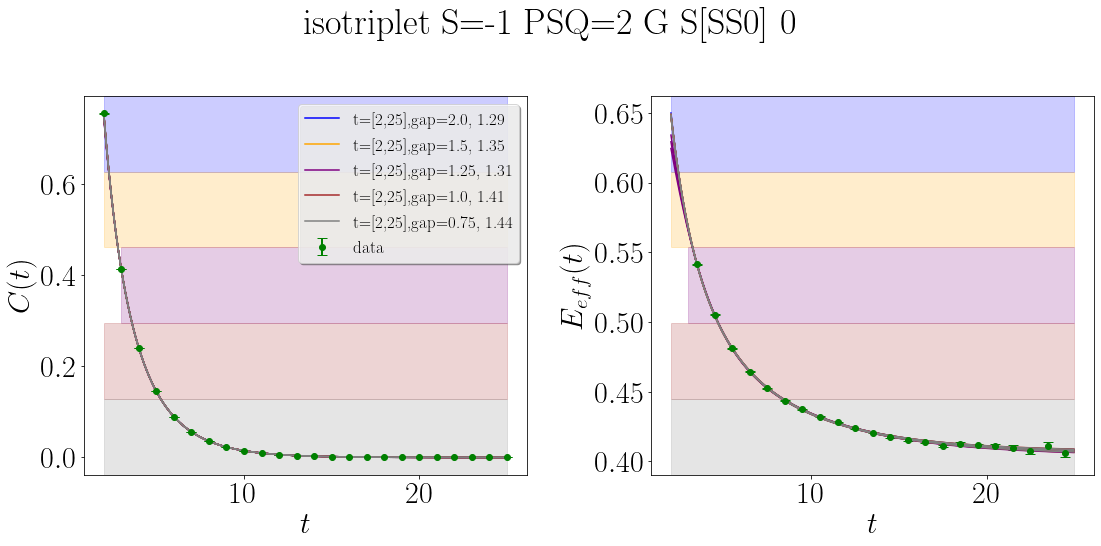

In [9]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figwidth(16)
f.set_figheight(8)
plot_tmin = 2
for corr in available_corrs:
    print(corr)
    ax1.clear()
    ax2.clear()
    f.suptitle(corr.replace("_"," "))
    i=0
    for data_file in data_files.keys():
        hdf5_data = h5py.File(data_file,"r")
        this_t, this_corr, this_err = utils.collectCorrEstimates(hdf5_data,corr,tag=data_files[data_file])
        if this_t:
            itmin = np.where(np.array(this_t)>=plot_tmin)[0][0]
            ax1.errorbar( this_t[itmin:], this_corr[itmin:],this_err[itmin:], label="data",  color=settings.colors[i], marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0 )
        this_t, this_corr, this_err = utils.collectEnergyEstimates(hdf5_data,corr,tag=data_files[data_file])
        if this_t:
            itmin = np.where(np.array(this_t)>=plot_tmin)[0][0]
            ax2.errorbar( this_t[itmin:], this_corr[itmin:],this_err[itmin:], label="data",  color=settings.colors[i], marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0 )
        
#         this_t, this_corr, this_err = utils.collectEnergyEstimates(hdf5_data,corr,tag=data_files[data_file],func=2)
#         if this_t:
#             ax2.errorbar( this_t, this_corr,this_err, label="data*",  color=settings.colors[i],mfc="white", marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0 )
        hdf5_data.close()
    i=1
    for dataset in param_files.keys():
        if dataset not in omit[corr]:
            hdf5_data = h5py.File(param_files[dataset],"r")
            tmin, tmax = get_fit_range(hdf5_data,corr)
            if tmin is not None:
                t = np.linspace(2.0,25.0,1000)
                itmin = np.where(t>=tmin)[0][0]
                itmax = np.where(t>=tmax)[0][0]
                itmin = np.where(t>=plot_tmin)[0][0]
                fit_vals = np.array([])
                try:
                    fit_vals, fit_errs = multi_exp_fit(hdf5_data,t,corr,"ct")
                except Exception as error:
                    print(error) #pass
                data_label = f"{dataset}, {round(hdf5_data['param_info'][corr].attrs['ChiSquarePerDof'],2)}"
                if fit_vals.any():
    #                 ax1.plot(t,fit_vals,ls="--",color=settings.colors[i])
    #                 ax1.plot(t,fit_vals+fit_errs,ls="--",color=settings.colors[i])
    #                 ax1.plot(t,fit_vals-fit_errs,ls="--",color=settings.colors[i])
                    ax1.axvspan(tmin, tmax, ymin=1.0-(i)/len(param_files),ymax=1.0-(i-1)/len(param_files), alpha=0.2,color=settings.colors[i])
                    ax1.plot(t[itmin:itmax],fit_vals[itmin:itmax],label=data_label,color=settings.colors[i])
                    ax1.plot(t[itmin:itmax],fit_vals[itmin:itmax]+fit_errs[itmin:itmax],color=settings.colors[i])
                    ax1.plot(t[itmin:itmax],fit_vals[itmin:itmax]-fit_errs[itmin:itmax],color=settings.colors[i])

                fit_vals = np.array([])
                try:
                    fit_vals, fit_errs = multi_exp_fit(hdf5_data,t,corr,"eff")
                except Exception as error:
                    print(error) #pass

                if fit_vals.any():
#                     try:
#                         stable_itmin = np.where(fit_errs>1.0)[0][-1]
#                     except:
#                         stable_itmin = np.where(fit_errs<1.0)[0][0]
                    ax2.axvspan(tmin, tmax, ymin=1.0-(i)/len(param_files),ymax=1.0-(i-1)/len(param_files), alpha=0.2,color=settings.colors[i])
                    ax2.plot(t[itmax:],fit_vals[itmax:],ls="--",color=settings.colors[i])
                    ax2.plot(t[itmax:],fit_vals[itmax:]+fit_errs[itmax:],ls="--",color=settings.colors[i])
                    ax2.plot(t[itmax:],fit_vals[itmax:]-fit_errs[itmax:],ls="--",color=settings.colors[i])
                    ax2.plot(t[itmin:itmax],fit_vals[itmin:itmax],label=data_label,color=settings.colors[i])
                    ax2.plot(t[itmin:itmax],fit_vals[itmin:itmax]+fit_errs[itmin:itmax],color=settings.colors[i])
                    ax2.plot(t[itmin:itmax],fit_vals[itmin:itmax]-fit_errs[itmin:itmax],color=settings.colors[i])

                hdf5_data.close()
                i+=1
    
    ax1.set_xlabel("$t$")
    ax1.set_ylabel("$C(t)$")
    ax2.set_xlabel("$t$")
    ax2.set_ylabel("$E_{eff}(t)$")
    ax1.legend()
        
    if corr==n_corr:
        john_data = pd.read_csv(johns_data_file, header=None,skiprows=6,delimiter="   ")
        ax2.errorbar(john_data[0],john_data[1],john_data[2],label="john",color=settings.colors[i], marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0)
#         ax2.legend()
        
    plt.tight_layout()
    plt.savefig(corr+".png")

In [10]:
hdf5_data = h5py.File("param_samplings_isosinglet_strange_fermionic_multi_rebin10.hdf5","r")
print(hdf5_data['params']['Values'].keys() )
hdf5_data.close()

<KeysViewHDF5 ['<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 112 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 12 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 212 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 312 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 412 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 512 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 612 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-L[SS0]-0T2-25 712 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-ROT-0T2-25 112 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-ROT-0T2-25 12 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-ROT-0T2-25 212 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-ROT-0T2-25 312 n re<|Info><|MCObservable>', '<MCObservable><Info>1-1000G1g-ROT-0T2-25 412 n re<|Info><|MCOb

In [11]:

hdf5_data.close()